In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

dta_inital = pd.read_csv("diabetic_data_initial.csv")
# remove indivuals which passed away, went to hospice, newborns, neonatal care
# Also, keep only first admissions
dta_filter = dta_inital[
    ~dta_inital["discharge_disposition_id"].isin([10, 13, 14, 19, 20, 21]) &
    (dta_inital["number_inpatient"] == 0) &
    (dta_inital["admission_type_id"] != 4) &
    (dta_inital["race"] != "?") & 
    (dta_inital["gender"] != "Unknown/Invalid") 
    ]

# Check whether each row refers to one patient
print(dta_filter["encounter_id"].nunique())
print(len(dta_filter))

65367
65367


In [ ]:
#function to aggregate ICD9 codes into disease groups
#I follow Strack et al. 2014 for grouping
def aggregate_diagnose(ICD9_code):
    try:
        ICD9_code = float(ICD9_code)
        if (390 <= ICD9_code <= 459) or (ICD9_code == 785):
            return "Circulatory"
        elif (460 <= ICD9_code <= 519) or (ICD9_code == 786):
            return "Respiratory"
        elif (520 <= ICD9_code <= 579) or (ICD9_code == 787):
            return "Digestive"
        elif 250 <= ICD9_code < 251:
            return "Diabetes"
        elif 800 <= ICD9_code <= 999:
            return "Injury"
        elif 710 <= ICD9_code <= 739:
            return "Musculoskeletal"
        elif (580 <= ICD9_code <= 629) or (ICD9_code == 788):
            return "Genitourinary"
        elif 140 <= ICD9_code <= 239:
            return "Neoplasms"
        else:
            return "Other"
    except:
        return "Other"  #other, we dont have missings in this variable but external codes such as V55

dta_filter.loc[:, "PrimaryDiagnose"] = dta_filter["diag_1"].apply(aggregate_diagnose)

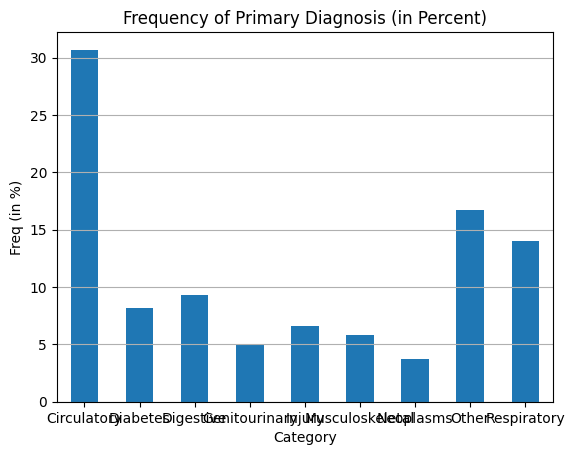

In [ ]:
percentages_PrimDiag = dta_filter["PrimaryDiagnose"].value_counts(normalize=True).sort_index() * 100
percentages_PrimDiag.plot(kind="bar")
plt.title("Frequency of Primary Diagnosis (in Percent)")
plt.xlabel("Category")
plt.ylabel("Freq (in %)")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

In [185]:
dta_filter["A1Cresult"].unique().tolist()

[nan, '>7', '>8', 'Norm']

In [ ]:
#Create feature HbA1c in accordance with Strack et al. 2014
no_test = pd.isna(dta_filter["A1Cresult"])
normal_test = dta_filter["A1Cresult"] == "Norm"
high_result_and_change = dta_filter["A1Cresult"].isin([">8", ">7"]) & (dta_filter["change"] == "Ch")
high_result_and_no_change = dta_filter["A1Cresult"].isin([">8", ">7"]) & (dta_filter["change"] == "No")

categories = ["no_test", "normal", "high_change", "high_no_change"]

dta_filter.loc[:, "HbA1c"] = np.select([no_test, normal_test,
                                        high_result_and_change,
                                        high_result_and_no_change],
                                        categories, default="other")

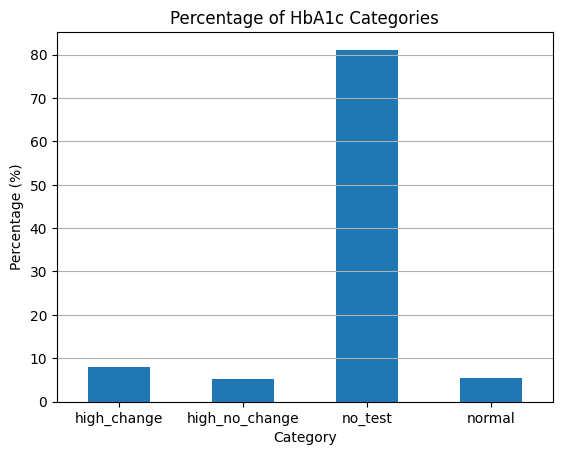

In [ ]:
percentages_HbA1c = dta_filter["HbA1c"].value_counts(normalize=True).sort_index() * 100

# Plot
percentages_HbA1c.plot(kind="bar")
plt.title("Percentage of HbA1c Categories")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.grid(axis="y")
plt.show()

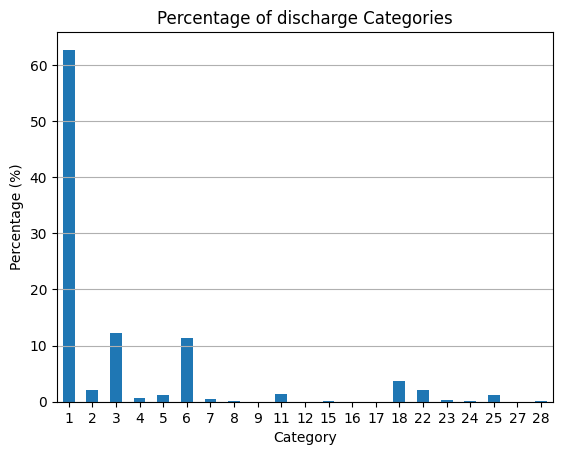

In [ ]:
#Check freq dist of variable
percentages_discharge = dta_filter["discharge_disposition_id"].value_counts(normalize=True).sort_index() * 100

# Plot
percentages_discharge.plot(kind='bar')
plt.title("Percentage of discharge Categories")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [ ]:
#aggregate based on plot above
to_home = dta_filter["discharge_disposition_id"] == 1

discharged = dta_filter["discharge_disposition_id"].isin(
    list(range(1, 9)) + list(range(15, 17 + 1)) + list(range(22, 24 + 1)) + list(range(27, 30 + 1))
)

deceased = dta_filter["discharge_disposition_id"].isin(
    [11] + list(range(19, 21 + 1))
)

unknown = dta_filter["discharge_disposition_id"].isin([18, 25, 26])

categories = ["to_home", "discharged", "deceased", "unknown"]

dta_filter.loc[:, "Discharge"] = np.select(
    [to_home, discharged, deceased, unknown],
    categories,
    default="other" 
)


dta_filter["Discharge"].unique().tolist()


['unknown', 'to_home', 'discharged', 'deceased', 'other']

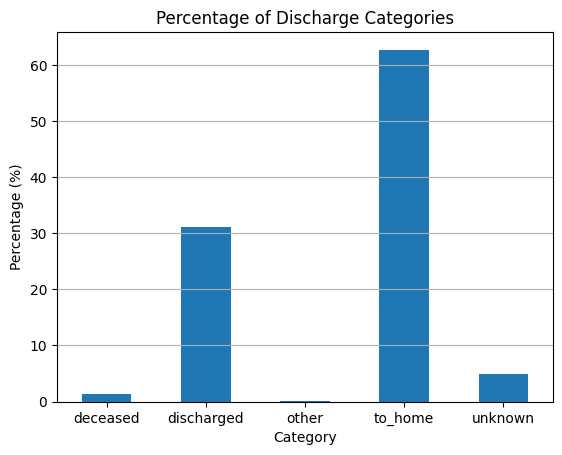

In [ ]:
#create new variable called Discharge
percentages_discharge = dta_filter["Discharge"].value_counts(normalize=True).sort_index() * 100

# Plot
percentages_discharge.plot(kind='bar')
plt.title("Percentage of Discharge Categories")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [ ]:
#remove cases where patient deceased or status unknown/other
dta_filter = dta_filter[dta_filter["Discharge"].isin(["to_home","discharged"])]

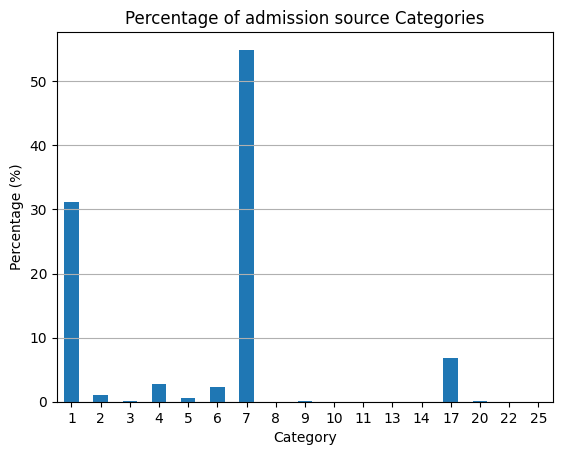

In [ ]:
#check freq dist of variable admission_source_id
percentages_source = dta_filter["admission_source_id"].value_counts(normalize=True).sort_index() * 100

# Plot
percentages_source.plot(kind='bar')
plt.title("Percentage of admission source Categories")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

In [ ]:
#aggregate those cases with high freq
emergency = dta_filter["admission_source_id"] == 7

Referral = dta_filter["admission_source_id"].isin([1,2])

Transfer = dta_filter["admission_source_id"].isin(
    [4,5,6,10,18,22,25,26]
)

Unknown = dta_filter["admission_source_id"].isin([17, 9, 20, 21])

categories = ["emergency", "referral", "transfer", "unknown"]

dta_filter.loc[:, "AdmissionSource"] = np.select(
    [emergency, Referral, Transfer, Unknown],
    categories,
    default="unknown" 
)


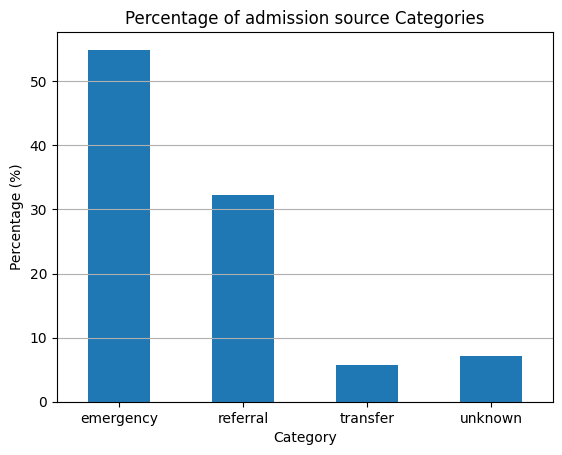

In [ ]:
#plot aggregated variable
percentages_source = dta_filter["AdmissionSource"].value_counts(normalize=True).sort_index() * 100

# Plot
percentages_source.plot(kind='bar')
plt.title("Percentage of admission source Categories")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=0)
plt.grid(axis='y')
plt.show()

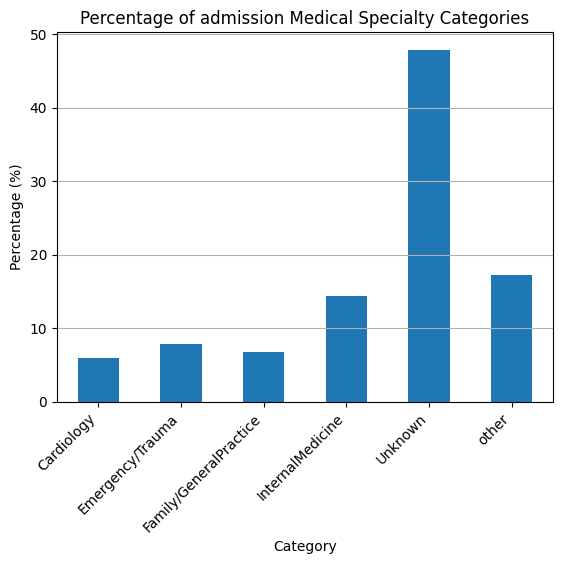

In [ ]:
#aggregate variable medical_specialty
freq = dta_filter["medical_specialty"].value_counts(normalize=True)
keep = freq[freq >= 0.035].index
dta_filter["MedicalSpecialty"] = dta_filter["medical_specialty"].where(dta_filter["medical_specialty"].isin(keep), other="other")
dta_filter["MedicalSpecialty"] = dta_filter["MedicalSpecialty"].replace("?", "Unknown")

percentages_source = dta_filter["MedicalSpecialty"].value_counts(normalize=True).sort_index() * 100

# Plot
percentages_source.plot(kind='bar')
plt.title("Percentage of admission Medical Specialty Categories")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.show()

In [ ]:
#get columns and index
for i, col in enumerate(dta_filter.columns):
    print(f"{i}: {col}")

0: encounter_id
1: patient_nbr
2: race
3: gender
4: age
5: weight
6: admission_type_id
7: discharge_disposition_id
8: admission_source_id
9: time_in_hospital
10: payer_code
11: medical_specialty
12: num_lab_procedures
13: num_procedures
14: num_medications
15: number_outpatient
16: number_emergency
17: number_inpatient
18: diag_1
19: diag_2
20: diag_3
21: number_diagnoses
22: max_glu_serum
23: A1Cresult
24: metformin
25: repaglinide
26: nateglinide
27: chlorpropamide
28: glimepiride
29: acetohexamide
30: glipizide
31: glyburide
32: tolbutamide
33: pioglitazone
34: rosiglitazone
35: acarbose
36: miglitol
37: troglitazone
38: tolazamide
39: examide
40: citoglipton
41: insulin
42: glyburide-metformin
43: glipizide-metformin
44: glimepiride-pioglitazone
45: metformin-rosiglitazone
46: metformin-pioglitazone
47: change
48: diabetesMed
49: readmitted
50: PrimaryDiagnose
51: HbA1c
52: Discharge
53: AdmissionSource
54: MedicalSpecialty


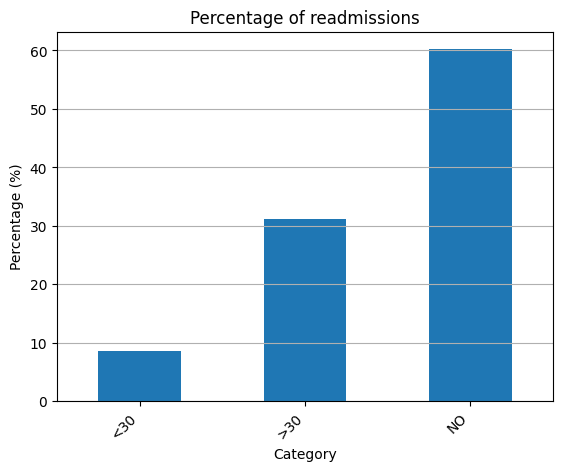

In [ ]:
#check freq dist of target variable
percentages_target = dta_filter["readmitted"].value_counts(normalize=True).sort_index() * 100

# Plot
percentages_target.plot(kind='bar')
plt.title("Percentage of readmissions")
plt.xlabel("Category")
plt.ylabel("Percentage (%)")
plt.xticks(rotation=45, ha="right")
plt.grid(axis='y')
plt.show()

In [ ]:
#get target, category 1 (i.e., <30) very small, hence oversampling in ML pipeline required 
dta_filter["target"] = (dta_filter["readmitted"] == "<30").astype(int)

#drop columns based on name
drop_cols = ["encounter_id", "patient_nbr", "weight", "admission_type_id",
             "discharge_disposition_id", "admission_source_id", "payer_code",
             "medical_specialty", "number_inpatient", "diag_1",
             "diag_2", "diag_3", "readmitted"]

#exlude meds as well because they show only one unique value or very few cases for other values (not shown)
drop_cols_meds = dta_filter.columns[24:47].tolist() #use index values from above

drop_cols = drop_cols + drop_cols_meds

final_dta = dta_filter.drop(columns=drop_cols)
len(final_dta)#number of cases is 61 275


61275

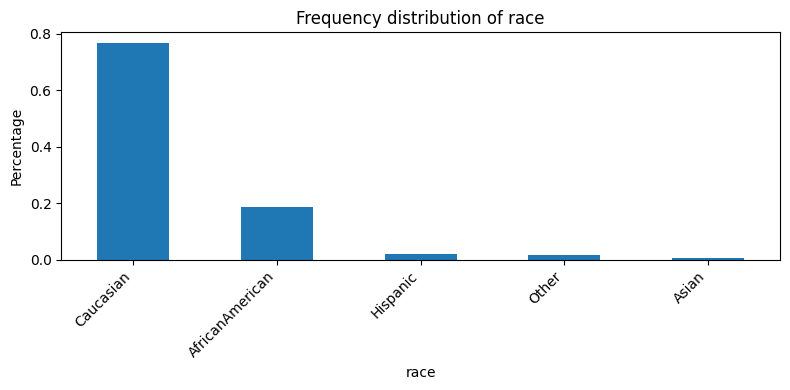

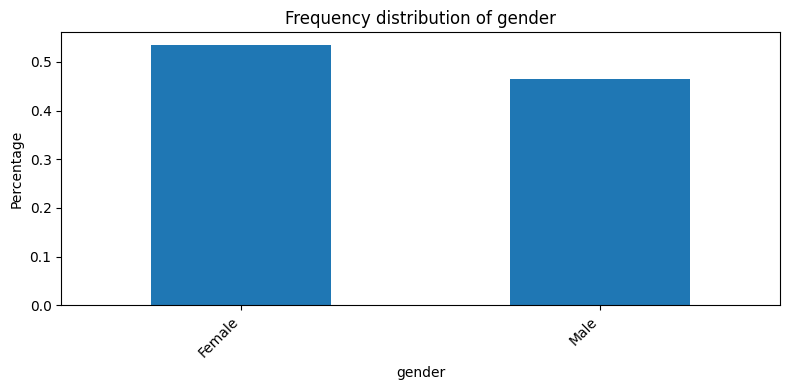

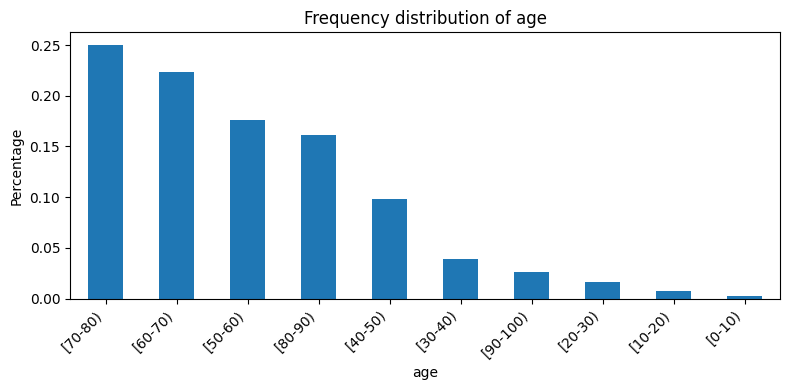

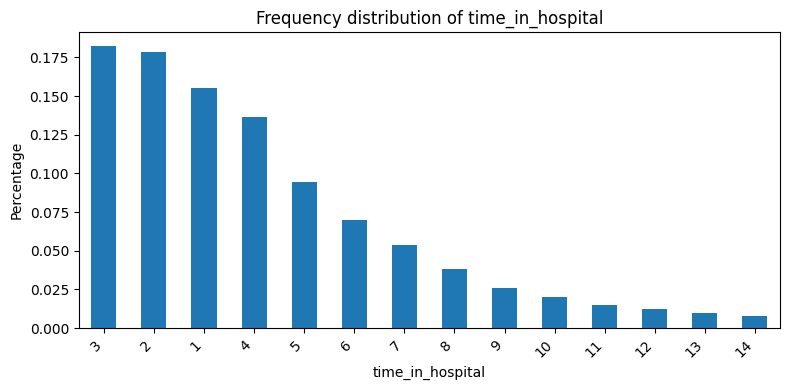

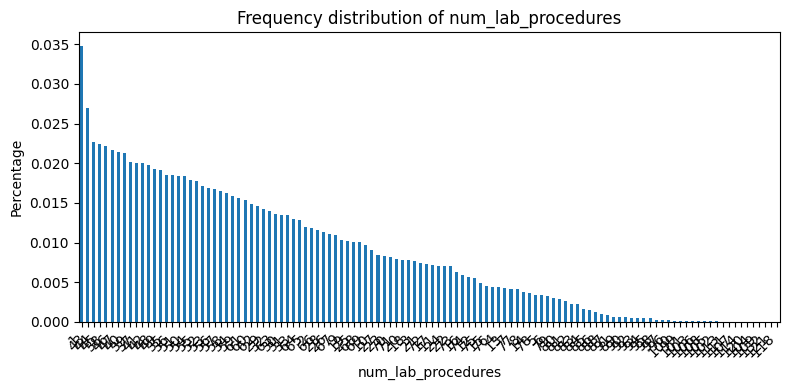

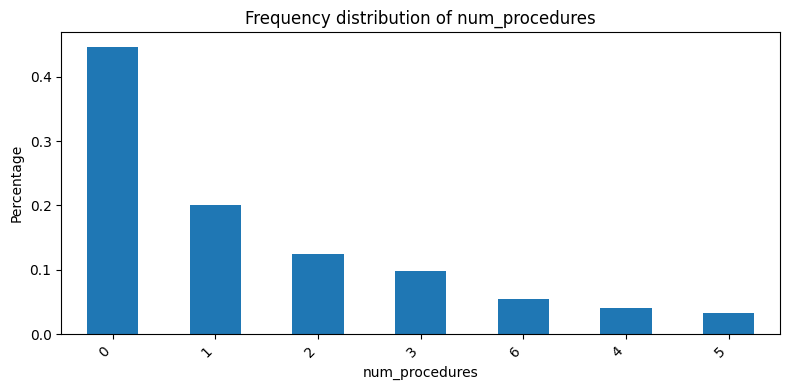

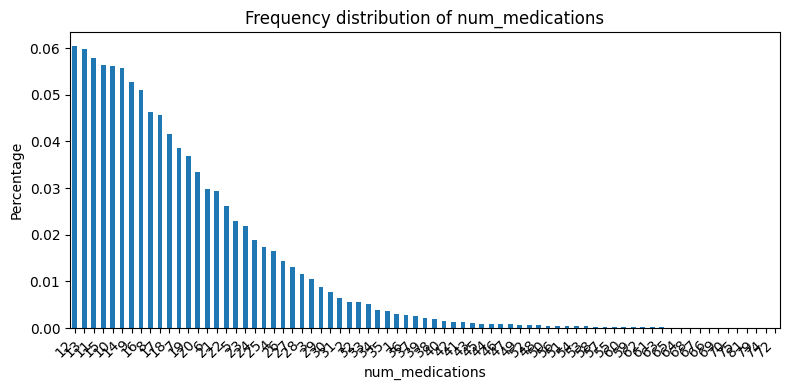

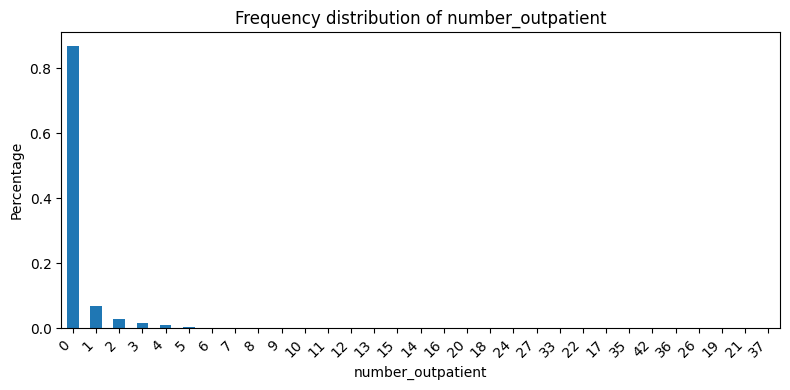

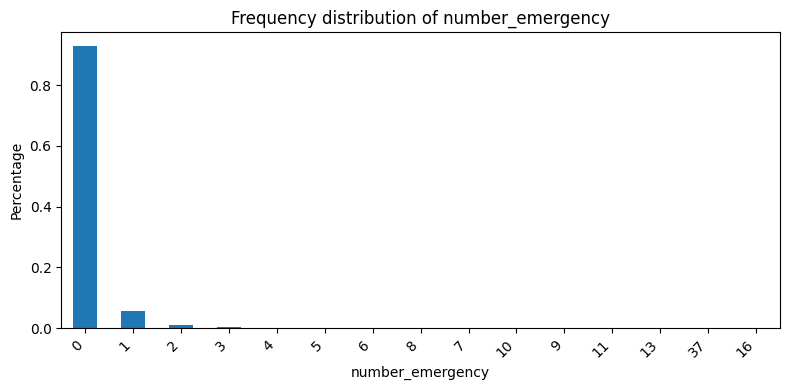

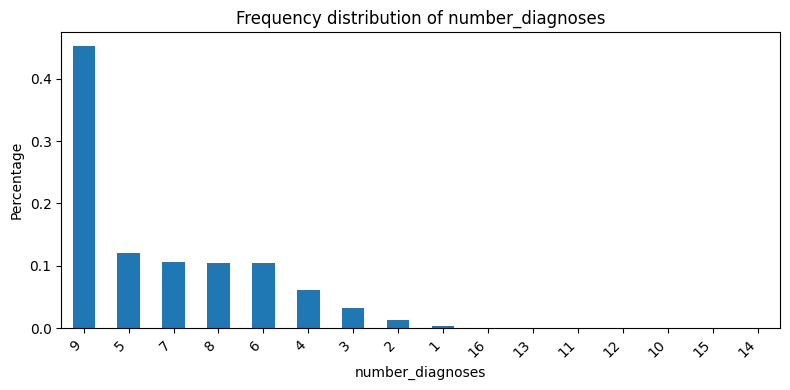

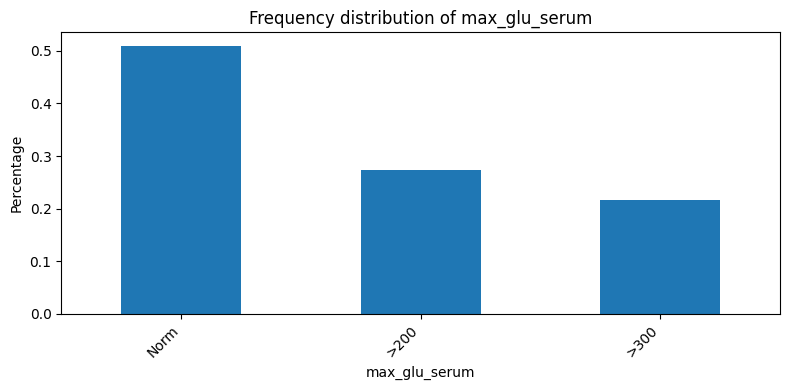

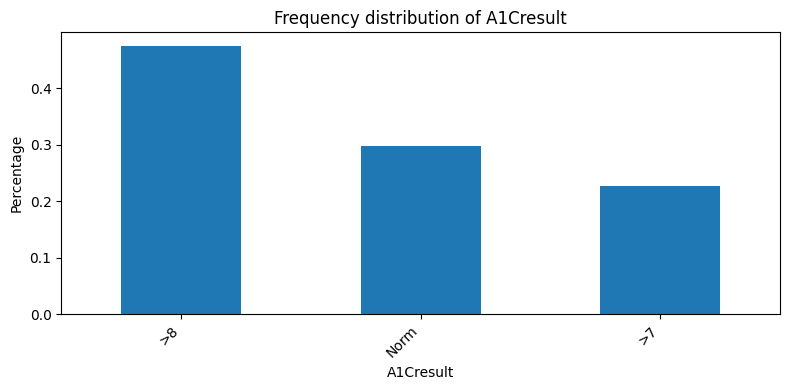

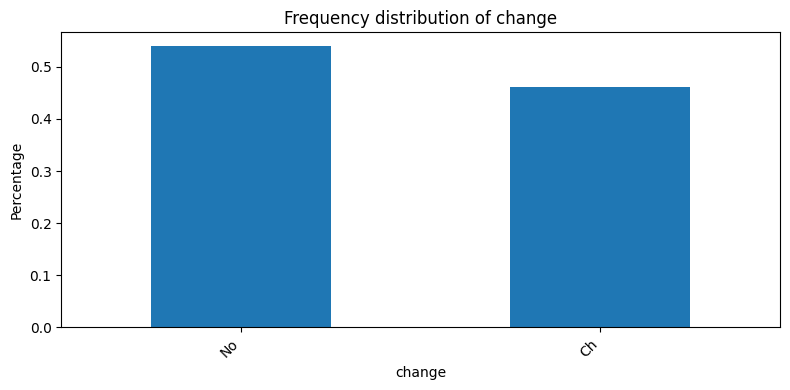

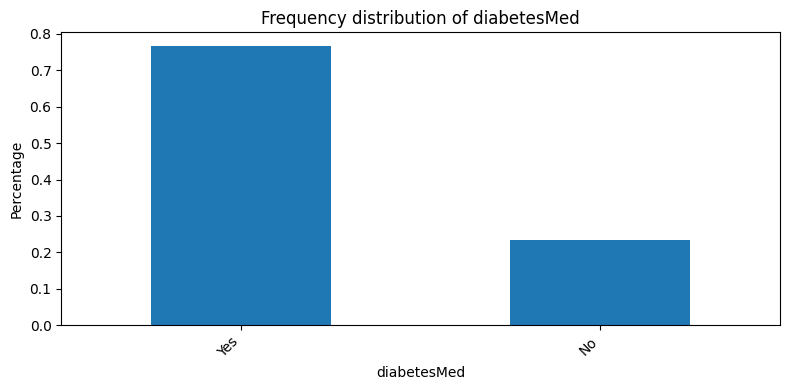

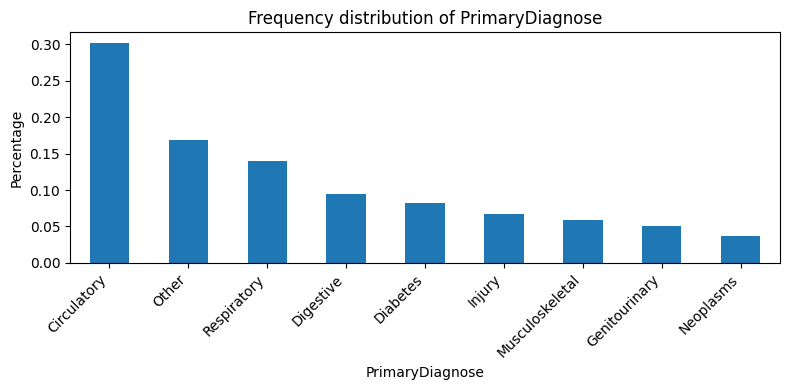

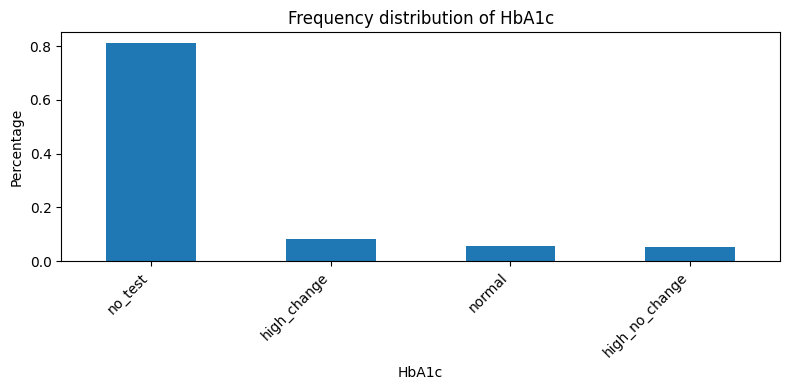

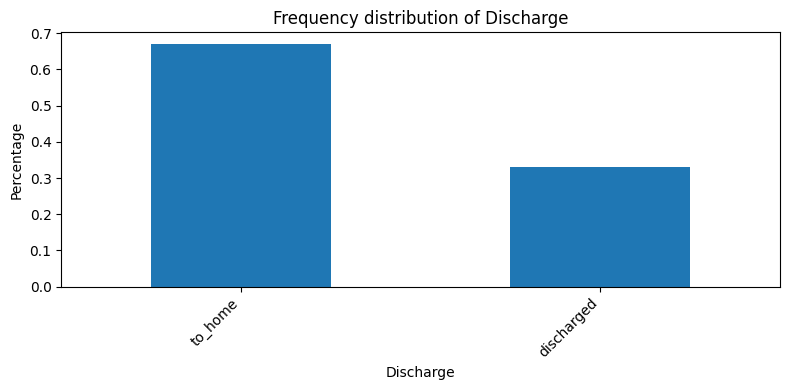

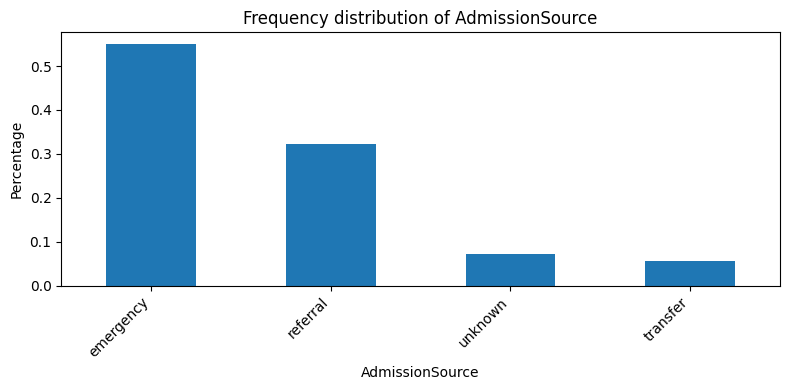

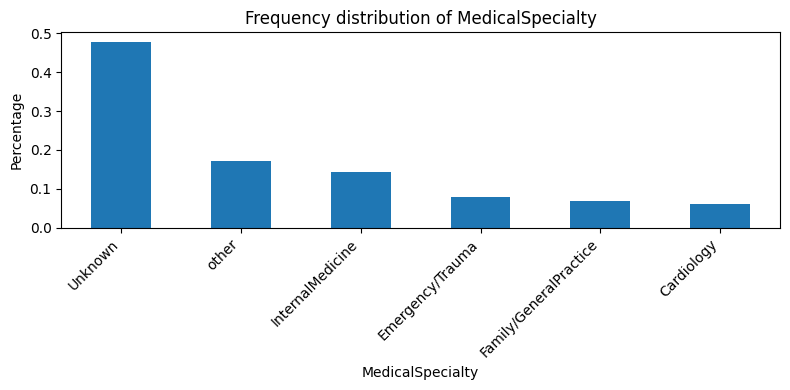

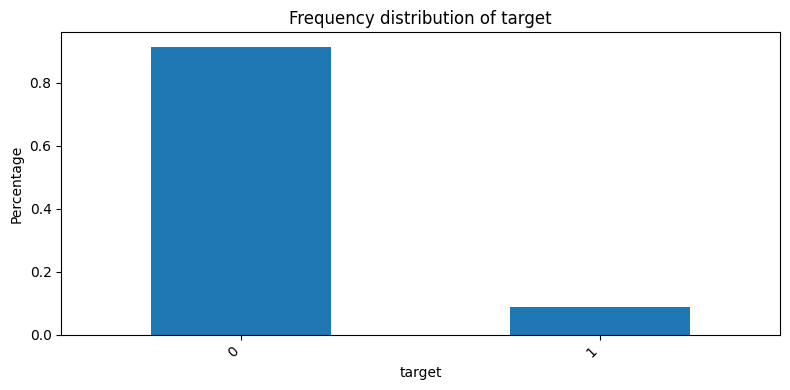

In [ ]:
#show freq dist for each variable
for col in final_dta.columns:
    plt.figure(figsize=(8, 4))
    final_dta[col].value_counts(normalize=True).plot(kind="bar")
    plt.title(f"Frequency distribution of {col}")
    plt.ylabel("Percentage")
    plt.xlabel(col)
    plt.xticks(rotation=45, ha="right")
    plt.tight_layout()
    plt.show()

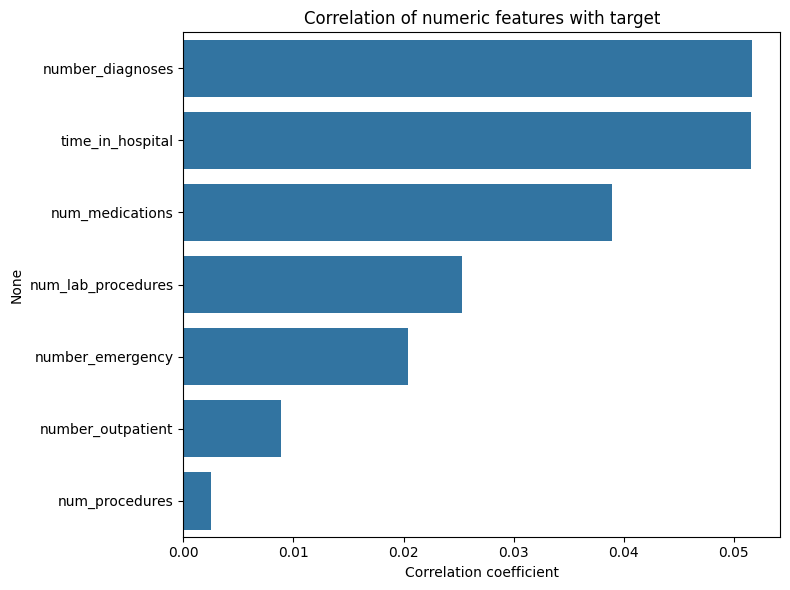

In [ ]:
# get simple correlation between target and features
# pearson for numeric, proportions for categorical values
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pointbiserialr

X = final_dta.drop(columns="target") 
y = final_dta["target"]

num_cols = X.select_dtypes(include=["int64", "float64"]).columns

correlations = {col: pointbiserialr(X[col], y)[0] for col in num_cols}
corr_series = pd.Series(correlations).sort_values(key=abs, ascending=False)

# Plot
plt.figure(figsize=(8, 6))
sns.barplot(x=corr_series.values, y=corr_series.index)
plt.title("Correlation of numeric features with target")
plt.xlabel("Correlation coefficient")
plt.tight_layout()
plt.show()

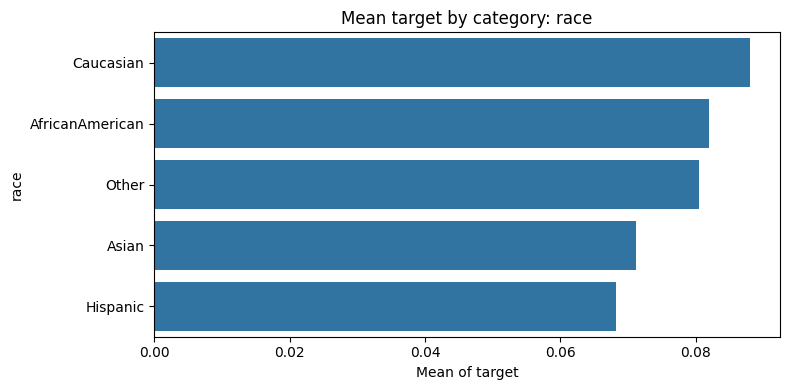

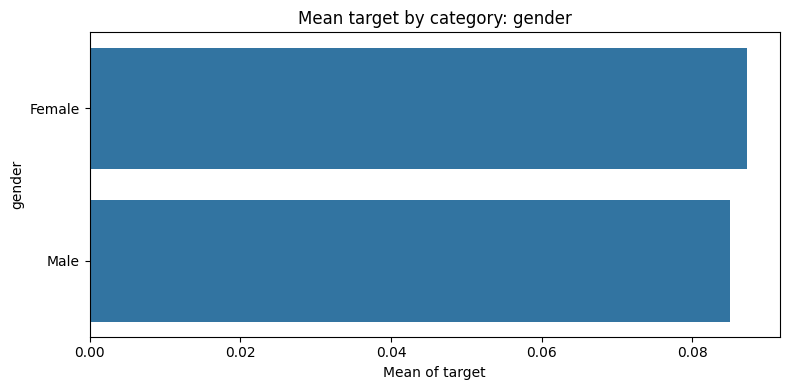

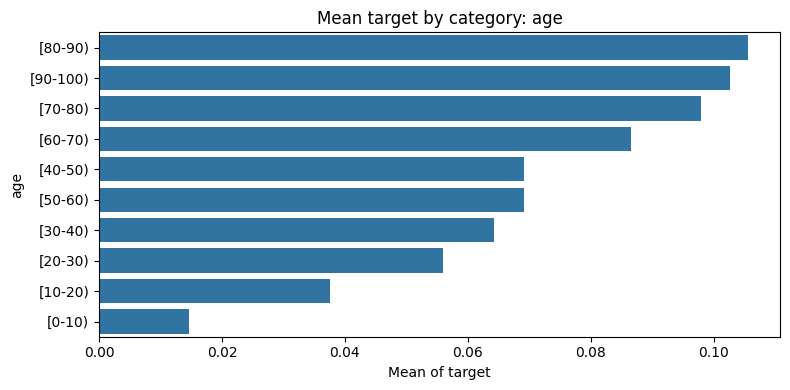

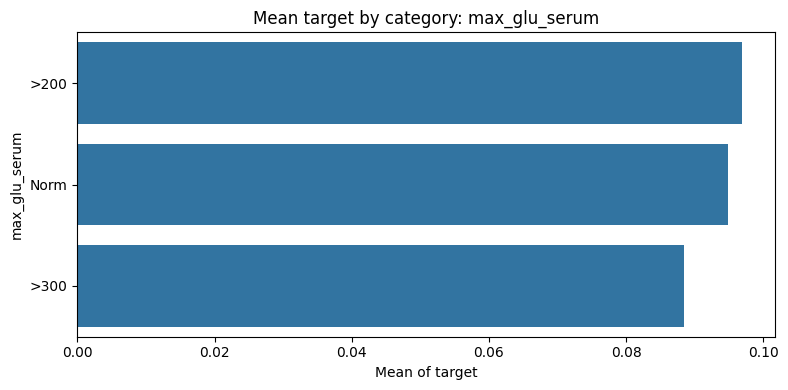

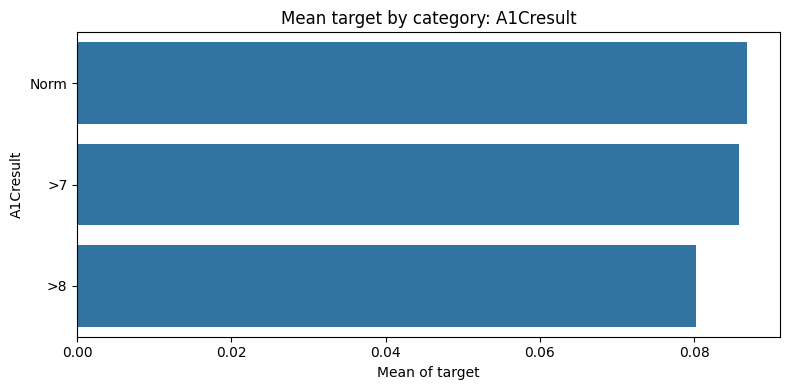

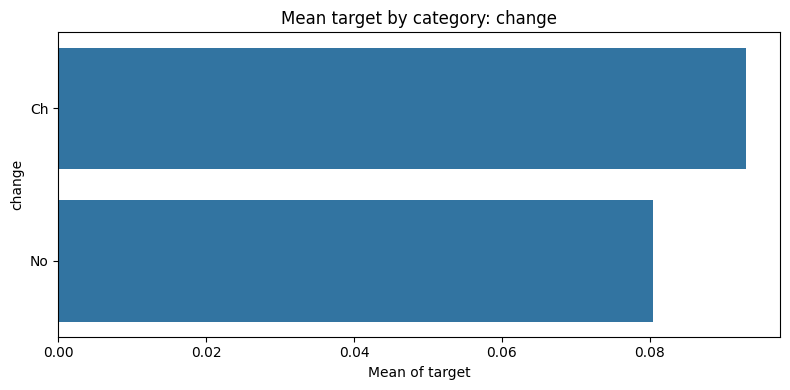

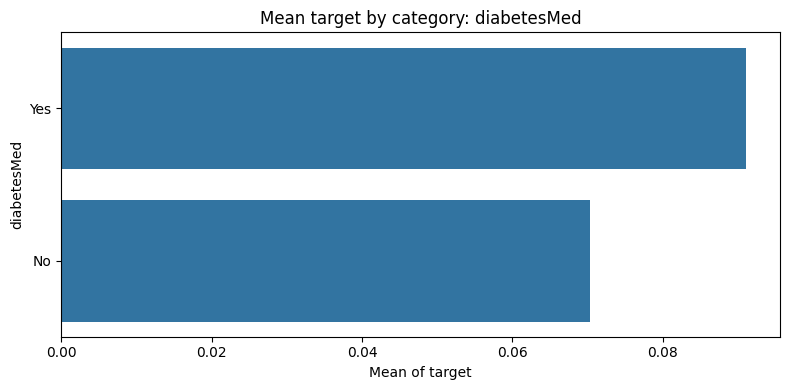

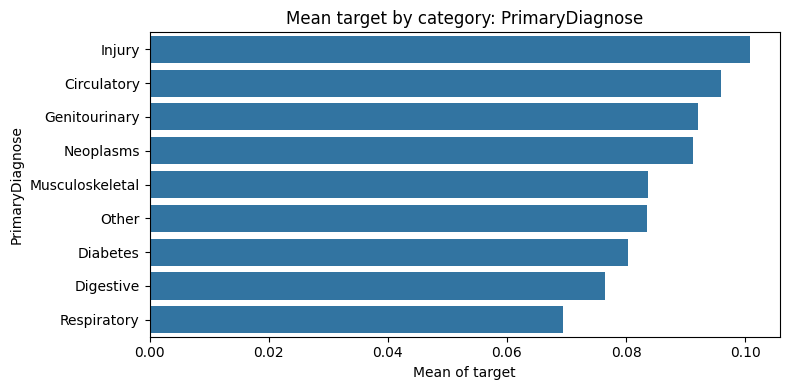

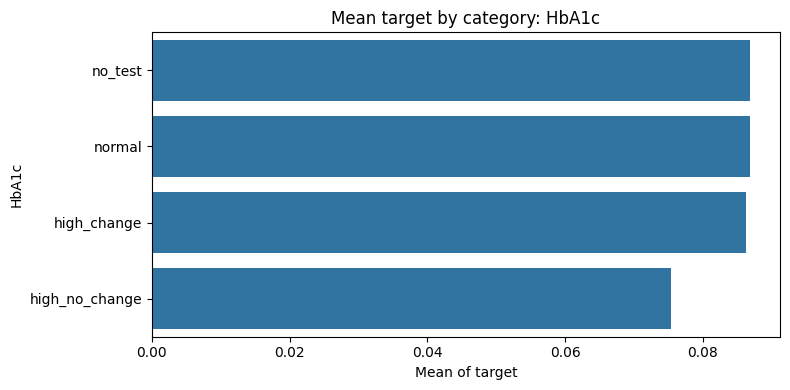

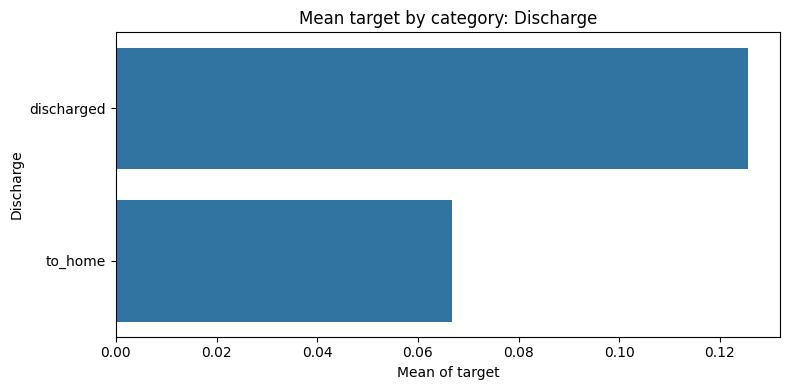

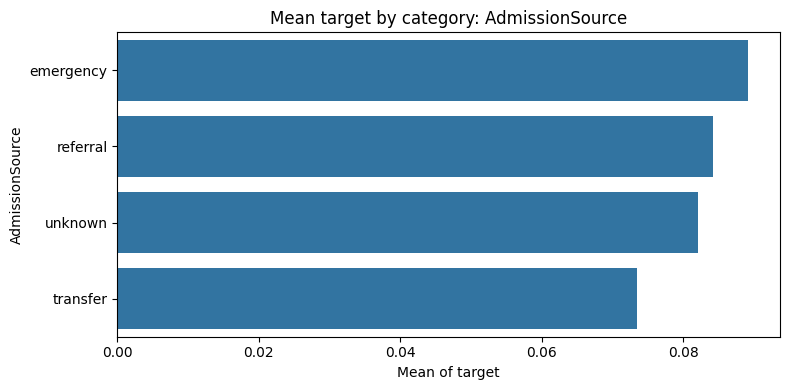

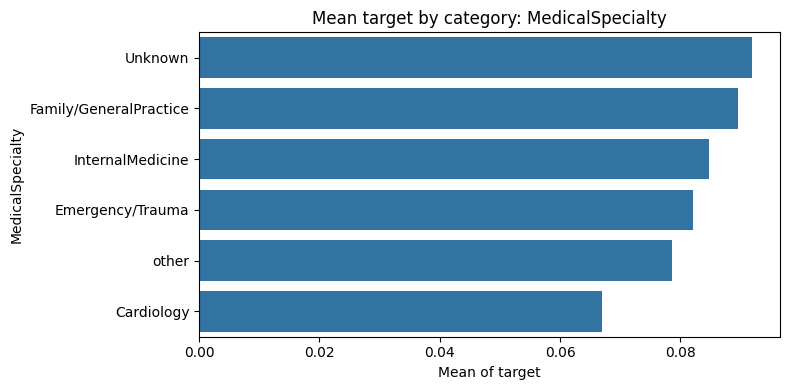

In [203]:
cat_cols = [col for col in X.columns if col not in num_cols]

for col in cat_cols:
    plt.figure(figsize=(8, 4))
    X_temp = pd.concat([X[col], y], axis=1)
    means = X_temp.groupby(col)[y.name].mean().sort_values(ascending=False)

    sns.barplot(x=means.values, y=means.index)
    plt.title(f"Mean target by category: {col}")
    plt.xlabel("Mean of target")
    plt.ylabel(col)
    plt.tight_layout()
    plt.show()

In [ ]:
final_dta.to_csv("data_preprocessed.csv", index=False)#save data